<a href="https://colab.research.google.com/github/wonjae124/2021_Lab_project/blob/main/(ToTensor)Strong_STL_10__DAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Set Dataset and model

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision import utils
from skimage.metrics import structural_similarity as ssim
import math
import cv2
import time
import os
from torchsummary import summary


In [3]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
    return device


In [4]:
# Define Loss function
def mse_loss(input, target):
    r = input[:,0:1,:,:] - target[:,0:1,:,:]
    g = (input[:,1:2,:,:] - target[:,1:2,:,:])
    b = input[:,2:3,:,:] - target[:,2:3,:,:]
    
    r = torch.mean(r**2)
    g = torch.mean(g**2)
    b = torch.mean(b**2)
    
    mean = (r + g + b)/3
   
    return mean

In [5]:
def Get_psnr(input, output, max_val=1.0):
    """
    Remark
    
    input type : tensor
    output type : float
    """
    input = input.cpu().clone().detach().numpy()
    output = output.cpu().clone().detach().numpy()

 #   print(np.max(input)) check. 1임.
 #   print(np.min(input)) ---> 0
 #   print(np.min(output)) ----> 0

    b = input[:,:,0]
    g = input[:,:,1]
    r = input[:,:,2]

    hat_b = output[:,:,0]
    hat_g = output[:,:,1]
    hat_r = output[:,:,2]

    b_img_diff = hat_b - b
    g_img_diff = hat_g - g 
    r_img_diff = hat_r - r
    
    b_mse = np.mean(b_img_diff**2)
    g_mse = np.mean(g_img_diff**2)
    r_mse = np.mean(r_img_diff**2)

    total_mse = r_mse + g_mse + b_mse
    

    if total_mse == 0:
      return 100
    else:
      psnr = 10 * math.log10( (max_val**2)/total_mse)
      return psnr 

In [6]:
batch_size = 2048
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [7]:
strong_transform = transforms.Compose([
                    transforms.ToTensor(),                     
                    transforms.GaussianBlur(kernel_size=(7,7),sigma=3), #
])

# weak/moderate/strong DataSet

Original Train/Validation/Test dataset

In [8]:
org_tr_set = datasets.STL10(root = "./data", split = "unlabeled", transform = transforms.ToTensor(), download=True)
tr_subset, val_subset = torch.utils.data.random_split(org_tr_set,[80000,20000],generator=torch.Generator().manual_seed(1))
test_set = datasets.STL10(root = "./data", split = "test",transform = transforms.ToTensor(), download=True)



Files already downloaded and verified
Files already downloaded and verified


# PILToTensor와 ToTensor의 차이, 
전자는 정규화를 하지 않는다.
0 부터 255인 uint8(그러므로 나중에 신경망에 넣을 때 float 변환 필요), 후자는 정규화를 하여서 0부터 1인 float가 된다.

단계를 나누어서 이미지에 노이즈를 가해보자

# opencv Gaussian blur를 가해보자.

Strong_hat Train/Validation/Test dataset


In [9]:
strong_hat_tr_set = datasets.STL10(root = "./data", split = "unlabeled", transform = strong_transform, download=False)
strong_hat_tr_subset, strong_hat_val_subset = torch.utils.data.random_split(strong_hat_tr_set,[80000,20000],generator=torch.Generator().manual_seed(1))
strong_hat_test_set = datasets.STL10(root = "./data", split = "test",transform = strong_transform, download=False)

# Check Image blur strengthen visaulazaiton

# Original / Gaussian Blur DataLoader

In [10]:
tr_dataloader = DataLoader(tr_subset, batch_size = batch_size, num_workers = 2, pin_memory=True)

val_dataloader = DataLoader(val_subset, batch_size = batch_size, num_workers = 2, pin_memory=True)

test_dataloader = DataLoader(test_set, batch_size = batch_size, num_workers = 2, pin_memory=True)


# Moderate Gaussian Blur DataLoader

# Strong Gaussian Blur

In [11]:
strong_hat_tr_dataloader = DataLoader(strong_hat_tr_subset, batch_size = batch_size, num_workers = 2, pin_memory=True)
strong_hat_val_dataloader = DataLoader(strong_hat_val_subset, batch_size = batch_size, num_workers = 2, pin_memory=True) # 여기서 hat_val_subset을 안 넣는 치명적인 실수.
strong_hat_test_dataloader = DataLoader(strong_hat_test_set, batch_size = batch_size, num_workers = 2, pin_memory=True)

In [12]:
print(len(tr_subset),len(val_subset), len(test_set))

80000 20000 8000


# Model. Setting parameter -> float

In [12]:
class DenosingAutoencoder(nn.Module):
  def __init__(self):
    super(DenosingAutoencoder, self).__init__()
    
    self.encoder = nn.Sequential(
    # 96 by 96 by 3
        nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 2, stride = 2, padding=0),
        nn.BatchNorm2d(32),
    # 48 by 48 by 32
        nn.ReLU(True),



        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 2, stride = 2, padding = 0),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
    # 24 by 24 by 64  

        nn.Conv2d(in_channels =64, out_channels = 128,  kernel_size = 2, stride = 2, padding=0),
    # 12 by 12 by 128 
        nn.BatchNorm2d(128),
        nn.ReLU(True),


        nn.Conv2d(in_channels = 128, out_channels = 256,  kernel_size = 2, stride = 2, padding=0),
        nn.BatchNorm2d(256),
    # 6 by 6 by 256
        nn.ReLU(True),


        nn.Flatten(start_dim=1),
    )
    self.decoder = nn.Sequential(
        nn.Unflatten(dim=1,unflattened_size = (256,6,6)),
    # 6 by 6 by 256

        nn.ConvTranspose2d(in_channels = 256, out_channels = 128,  kernel_size = 2, stride = 2, padding=0),
        nn.BatchNorm2d(128),
        nn.ReLU(True),

    # 12 by 12 by 128  
        
        nn.ConvTranspose2d(in_channels = 128, out_channels = 64,  kernel_size = 2, stride = 2, padding=0),
        nn.BatchNorm2d(64),
        nn.ReLU(True),


    # 24 by 24 by 64
        nn.ConvTranspose2d(in_channels = 64, out_channels = 32,  kernel_size = 2, stride = 2, padding=0),
        nn.BatchNorm2d(32),
        nn.ReLU(True),   
    
    # 48 by 48 by 32

        nn.ConvTranspose2d(in_channels = 32, out_channels = 3, kernel_size = 2, stride = 2, padding=0),
        nn.BatchNorm2d(3),

    # 96 by 96 by 3
        nn.Sigmoid())
  
  def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# Strong DAE train Mode

cuda
Epoch : [1/300] 

Training Loss: 0.043356	 validation Loss 0.037063
Epoch : [2/300] 

Training Loss: 0.020356	 validation Loss 0.025206
Epoch : [3/300] 

Training Loss: 0.015392	 validation Loss 0.021932
Epoch : [4/300] 

Training Loss: 0.012959	 validation Loss 0.019098
Epoch : [5/300] 

Training Loss: 0.011004	 validation Loss 0.015379
PNSR :13.41 	 SSIM : 0.65
PNSR :10.95 	 SSIM : 0.57
PNSR :10.40 	 SSIM : 0.37
PNSR :19.58 	 SSIM : 0.69
PNSR :17.26 	 SSIM : 0.62


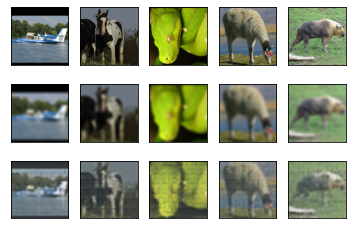

Epoch : [6/300] 

Training Loss: 0.009626	 validation Loss 0.013202
Epoch : [7/300] 

Training Loss: 0.008698	 validation Loss 0.011761
Epoch : [8/300] 

Training Loss: 0.007950	 validation Loss 0.010662
Epoch : [9/300] 

Training Loss: 0.007360	 validation Loss 0.009575
Epoch : [10/300] 

Training Loss: 0.006918	 validation Loss 0.009196
PNSR :16.40 	 SSIM : 0.70
PNSR :13.69 	 SSIM : 0.65
PNSR :13.57 	 SSIM : 0.54
PNSR :21.76 	 SSIM : 0.76
PNSR :18.75 	 SSIM : 0.68


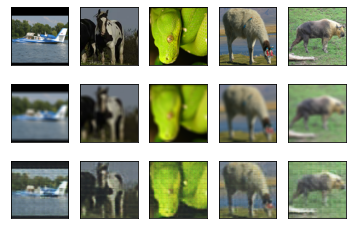

Epoch : [11/300] 

Training Loss: 0.006527	 validation Loss 0.008402
Epoch : [12/300] 

Training Loss: 0.006209	 validation Loss 0.007977
Epoch : [13/300] 

Training Loss: 0.006002	 validation Loss 0.006942
Epoch : [14/300] 

Training Loss: 0.005642	 validation Loss 0.007588
Epoch : [15/300] 

Training Loss: 0.005546	 validation Loss 0.006731
PNSR :18.56 	 SSIM : 0.74
PNSR :15.78 	 SSIM : 0.72
PNSR :16.70 	 SSIM : 0.59
PNSR :22.53 	 SSIM : 0.80
PNSR :19.42 	 SSIM : 0.72


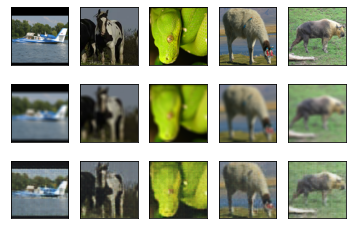

Epoch : [16/300] 

Training Loss: 0.005343	 validation Loss 0.006714
Epoch : [17/300] 

Training Loss: 0.005189	 validation Loss 0.006557
Epoch : [18/300] 

Training Loss: 0.005047	 validation Loss 0.006493
Epoch : [19/300] 

Training Loss: 0.004985	 validation Loss 0.006495
Epoch : [20/300] 

Training Loss: 0.004854	 validation Loss 0.005825
PNSR :19.48 	 SSIM : 0.75
PNSR :16.22 	 SSIM : 0.74
PNSR :18.23 	 SSIM : 0.61
PNSR :22.92 	 SSIM : 0.82
PNSR :19.50 	 SSIM : 0.74


Epoch : [21/300] 

Training Loss: 0.004755	 validation Loss 0.006078
Epoch : [22/300] 

Training Loss: 0.004690	 validation Loss 0.005648
Epoch : [23/300] 

Training Loss: 0.004621	 validation Loss 0.005363
Epoch : [24/300] 

Training Loss: 0.004531	 validation Loss 0.005602
Epoch : [25/300] 

Training Loss: 0.004451	 validation Loss 0.005541
PNSR :20.43 	 SSIM : 0.76
PNSR :16.81 	 SSIM : 0.76
PNSR :18.87 	 SSIM : 0.62
PNSR :22.83 	 SSIM : 0.82
PNSR :20.03 	 SSIM : 0.74


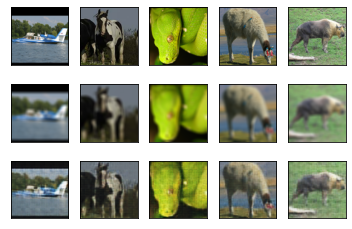

Epoch : [26/300] 

Training Loss: 0.004432	 validation Loss 0.005068
Epoch : [27/300] 

Training Loss: 0.004365	 validation Loss 0.005354
Epoch : [28/300] 

Training Loss: 0.004320	 validation Loss 0.005685
Epoch : [29/300] 

Training Loss: 0.004272	 validation Loss 0.005335
Epoch : [30/300] 

Training Loss: 0.004272	 validation Loss 0.005024
PNSR :20.68 	 SSIM : 0.77
PNSR :17.16 	 SSIM : 0.78
PNSR :19.22 	 SSIM : 0.65
PNSR :23.35 	 SSIM : 0.83
PNSR :20.27 	 SSIM : 0.75


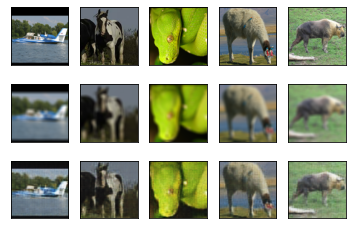

Epoch : [31/300] 

Training Loss: 0.004251	 validation Loss 0.004852
Epoch : [32/300] 

Training Loss: 0.004145	 validation Loss 0.005605
Epoch : [33/300] 

Training Loss: 0.004155	 validation Loss 0.005377
Epoch : [34/300] 

Training Loss: 0.004169	 validation Loss 0.004985
Epoch : [35/300] 

Training Loss: 0.004091	 validation Loss 0.004908
PNSR :20.47 	 SSIM : 0.78
PNSR :16.93 	 SSIM : 0.79
PNSR :19.75 	 SSIM : 0.65
PNSR :22.89 	 SSIM : 0.84
PNSR :20.42 	 SSIM : 0.76


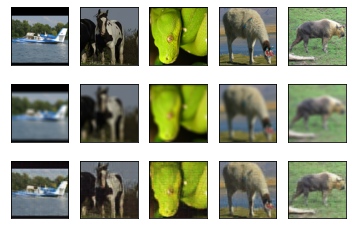

Epoch : [36/300] 

Training Loss: 0.004031	 validation Loss 0.005169
Epoch : [37/300] 

Training Loss: 0.004038	 validation Loss 0.004844
Epoch : [38/300] 

Training Loss: 0.004016	 validation Loss 0.004818
Epoch : [39/300] 

Training Loss: 0.003975	 validation Loss 0.004819
Epoch : [40/300] 

Training Loss: 0.003931	 validation Loss 0.004982
PNSR :21.28 	 SSIM : 0.77
PNSR :18.03 	 SSIM : 0.80
PNSR :20.80 	 SSIM : 0.66
PNSR :22.72 	 SSIM : 0.83
PNSR :20.31 	 SSIM : 0.76


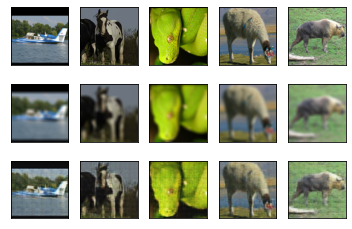

Epoch : [41/300] 

Training Loss: 0.003939	 validation Loss 0.004804
Epoch : [42/300] 

Training Loss: 0.003903	 validation Loss 0.005125
Epoch : [43/300] 

Training Loss: 0.003890	 validation Loss 0.004867
Epoch : [44/300] 

Training Loss: 0.003887	 validation Loss 0.004684
Epoch : [45/300] 

Training Loss: 0.003844	 validation Loss 0.004806
PNSR :21.39 	 SSIM : 0.78
PNSR :17.86 	 SSIM : 0.79
PNSR :21.48 	 SSIM : 0.67
PNSR :23.31 	 SSIM : 0.82
PNSR :20.66 	 SSIM : 0.75


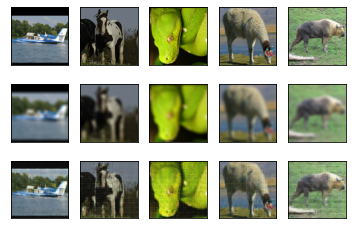

Epoch : [46/300] 

Training Loss: 0.003820	 validation Loss 0.004894
Epoch : [47/300] 

Training Loss: 0.003866	 validation Loss 0.004507
Epoch : [48/300] 

Training Loss: 0.003773	 validation Loss 0.004731
Epoch : [49/300] 

Training Loss: 0.003776	 validation Loss 0.004423
Epoch : [50/300] 

Training Loss: 0.003730	 validation Loss 0.004526
PNSR :21.78 	 SSIM : 0.78
PNSR :18.24 	 SSIM : 0.81
PNSR :21.99 	 SSIM : 0.68
PNSR :23.40 	 SSIM : 0.83
PNSR :20.56 	 SSIM : 0.77


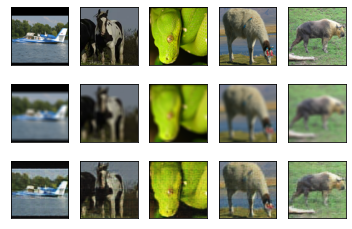

Epoch : [51/300] 

Training Loss: 0.003698	 validation Loss 0.004911
Epoch : [52/300] 

Training Loss: 0.003718	 validation Loss 0.004763
Epoch : [53/300] 

Training Loss: 0.003699	 validation Loss 0.004693
Epoch : [54/300] 

Training Loss: 0.003679	 validation Loss 0.004559
Epoch : [55/300] 

Training Loss: 0.003661	 validation Loss 0.004537
PNSR :21.96 	 SSIM : 0.78
PNSR :18.43 	 SSIM : 0.81
PNSR :21.74 	 SSIM : 0.70
PNSR :23.05 	 SSIM : 0.83
PNSR :20.18 	 SSIM : 0.76


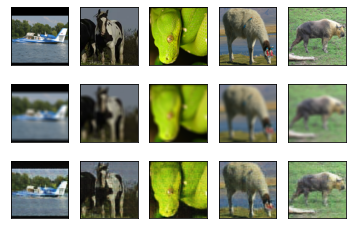

Epoch : [56/300] 

Training Loss: 0.003624	 validation Loss 0.004686
Epoch : [57/300] 

Training Loss: 0.003631	 validation Loss 0.004261
Epoch : [58/300] 

Training Loss: 0.003589	 validation Loss 0.004561
Epoch : [59/300] 

Training Loss: 0.003627	 validation Loss 0.004188
Epoch : [60/300] 

Training Loss: 0.003584	 validation Loss 0.005160
PNSR :21.44 	 SSIM : 0.75
PNSR :18.83 	 SSIM : 0.80
PNSR :22.95 	 SSIM : 0.66
PNSR :21.46 	 SSIM : 0.80
PNSR :19.95 	 SSIM : 0.72


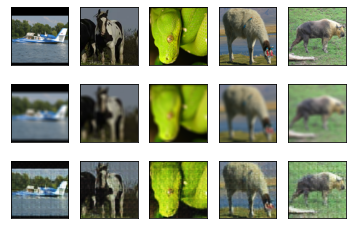

Epoch : [61/300] 

Training Loss: 0.003577	 validation Loss 0.004217
Epoch : [62/300] 

Training Loss: 0.003553	 validation Loss 0.004325
Epoch : [63/300] 

Training Loss: 0.003549	 validation Loss 0.004311
Epoch : [64/300] 

Training Loss: 0.003532	 validation Loss 0.004339
Epoch : [65/300] 

Training Loss: 0.003535	 validation Loss 0.004149
PNSR :22.52 	 SSIM : 0.81
PNSR :18.89 	 SSIM : 0.83
PNSR :23.46 	 SSIM : 0.71
PNSR :23.48 	 SSIM : 0.84
PNSR :20.51 	 SSIM : 0.77


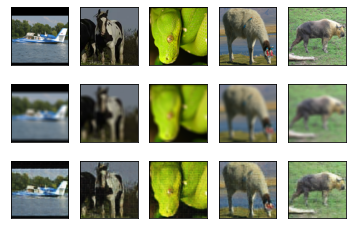

Epoch : [66/300] 

Training Loss: 0.003579	 validation Loss 0.004354
Epoch : [67/300] 

Training Loss: 0.003494	 validation Loss 0.004466
Epoch : [68/300] 

Training Loss: 0.003489	 validation Loss 0.004175
Epoch : [69/300] 

Training Loss: 0.003502	 validation Loss 0.004462
Epoch : [70/300] 

Training Loss: 0.003456	 validation Loss 0.004399
PNSR :22.42 	 SSIM : 0.79
PNSR :19.08 	 SSIM : 0.82
PNSR :23.84 	 SSIM : 0.70
PNSR :23.50 	 SSIM : 0.83
PNSR :19.94 	 SSIM : 0.75


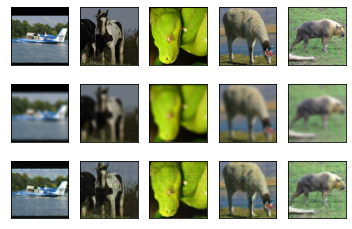

Epoch : [71/300] 

Training Loss: 0.003524	 validation Loss 0.004637
Epoch : [72/300] 

Training Loss: 0.003481	 validation Loss 0.004457
Epoch : [73/300] 

Training Loss: 0.003473	 validation Loss 0.004761
Epoch : [74/300] 

Training Loss: 0.003463	 validation Loss 0.004095
Epoch : [75/300] 

Training Loss: 0.003441	 validation Loss 0.004433
PNSR :22.22 	 SSIM : 0.78
PNSR :18.68 	 SSIM : 0.82
PNSR :22.43 	 SSIM : 0.69
PNSR :23.61 	 SSIM : 0.82
PNSR :20.82 	 SSIM : 0.75


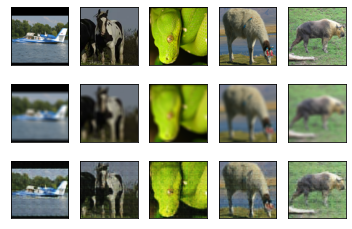

Epoch : [76/300] 

Training Loss: 0.003440	 validation Loss 0.004265
Epoch : [77/300] 

Training Loss: 0.003431	 validation Loss 0.004388
Epoch : [78/300] 

Training Loss: 0.003468	 validation Loss 0.004315
Epoch : [79/300] 

Training Loss: 0.003417	 validation Loss 0.004271
Epoch : [80/300] 

Training Loss: 0.003395	 validation Loss 0.004132
PNSR :22.98 	 SSIM : 0.80
PNSR :19.84 	 SSIM : 0.84
PNSR :24.87 	 SSIM : 0.72
PNSR :23.08 	 SSIM : 0.84
PNSR :20.23 	 SSIM : 0.77


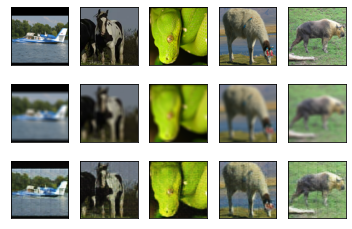

Epoch : [81/300] 

Training Loss: 0.003418	 validation Loss 0.004160
Epoch : [82/300] 

Training Loss: 0.003423	 validation Loss 0.004182
Epoch : [83/300] 

Training Loss: 0.003400	 validation Loss 0.004089
Epoch : [84/300] 

Training Loss: 0.003400	 validation Loss 0.004704
Epoch : [85/300] 

Training Loss: 0.003403	 validation Loss 0.003971
PNSR :22.20 	 SSIM : 0.80
PNSR :19.73 	 SSIM : 0.84
PNSR :23.43 	 SSIM : 0.71
PNSR :23.74 	 SSIM : 0.84
PNSR :20.19 	 SSIM : 0.76


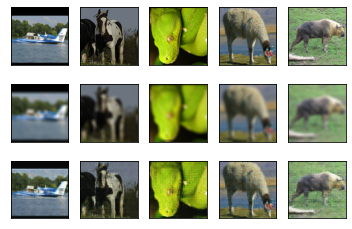

Epoch : [86/300] 

Training Loss: 0.003370	 validation Loss 0.004017
Epoch : [87/300] 

Training Loss: 0.003393	 validation Loss 0.004213
Epoch : [88/300] 

Training Loss: 0.003399	 validation Loss 0.004101
Epoch : [89/300] 

Training Loss: 0.003343	 validation Loss 0.004150
Epoch : [90/300] 

Training Loss: 0.003368	 validation Loss 0.003899
PNSR :23.27 	 SSIM : 0.81
PNSR :19.09 	 SSIM : 0.84
PNSR :23.06 	 SSIM : 0.72
PNSR :23.66 	 SSIM : 0.84
PNSR :20.64 	 SSIM : 0.78


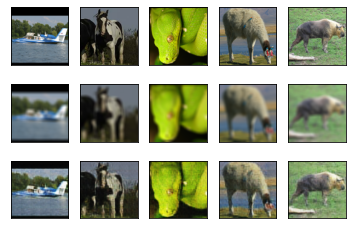

Epoch : [91/300] 

Training Loss: 0.003387	 validation Loss 0.004164
Epoch : [92/300] 

Training Loss: 0.003330	 validation Loss 0.004325
Epoch : [93/300] 

Training Loss: 0.003401	 validation Loss 0.004720
Epoch : [94/300] 

Training Loss: 0.003340	 validation Loss 0.004269
Epoch : [95/300] 

Training Loss: 0.003362	 validation Loss 0.004357
PNSR :22.22 	 SSIM : 0.79
PNSR :18.99 	 SSIM : 0.82
PNSR :23.15 	 SSIM : 0.70
PNSR :22.76 	 SSIM : 0.82
PNSR :19.96 	 SSIM : 0.75


Epoch : [96/300] 

Training Loss: 0.003335	 validation Loss 0.003992
Epoch : [97/300] 

Training Loss: 0.003348	 validation Loss 0.004395
Epoch : [98/300] 

Training Loss: 0.003340	 validation Loss 0.004270
Epoch : [99/300] 

Training Loss: 0.003322	 validation Loss 0.003911
Epoch : [100/300] 

Training Loss: 0.003323	 validation Loss 0.004641
PNSR :21.14 	 SSIM : 0.77
PNSR :18.55 	 SSIM : 0.81
PNSR :21.43 	 SSIM : 0.69
PNSR :20.99 	 SSIM : 0.81
PNSR :19.35 	 SSIM : 0.74


Epoch : [101/300] 

Training Loss: 0.003318	 validation Loss 0.004572
Epoch : [102/300] 

Training Loss: 0.003366	 validation Loss 0.004262
Epoch : [103/300] 

Training Loss: 0.003292	 validation Loss 0.004196
Epoch : [104/300] 

Training Loss: 0.003293	 validation Loss 0.004281
Epoch : [105/300] 

Training Loss: 0.003333	 validation Loss 0.004184
PNSR :22.64 	 SSIM : 0.79
PNSR :19.30 	 SSIM : 0.83
PNSR :23.57 	 SSIM : 0.71
PNSR :22.88 	 SSIM : 0.82
PNSR :20.76 	 SSIM : 0.76


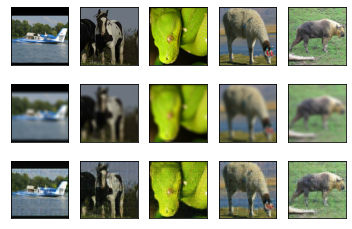

Epoch : [106/300] 

Training Loss: 0.003304	 validation Loss 0.004120
Epoch : [107/300] 

Training Loss: 0.003283	 validation Loss 0.004008
Epoch : [108/300] 

Training Loss: 0.003304	 validation Loss 0.004188
Epoch : [109/300] 

Training Loss: 0.003301	 validation Loss 0.005765
Epoch : [110/300] 

Training Loss: 0.003355	 validation Loss 0.003890
PNSR :23.42 	 SSIM : 0.81
PNSR :19.74 	 SSIM : 0.85
PNSR :24.75 	 SSIM : 0.73
PNSR :23.40 	 SSIM : 0.84
PNSR :20.81 	 SSIM : 0.78


Epoch : [111/300] 

Training Loss: 0.003263	 validation Loss 0.004267
Epoch : [112/300] 

Training Loss: 0.003287	 validation Loss 0.004067
Epoch : [113/300] 

Training Loss: 0.003263	 validation Loss 0.004329
Epoch : [114/300] 

Training Loss: 0.003288	 validation Loss 0.003905
Epoch : [115/300] 

Training Loss: 0.003260	 validation Loss 0.004473
PNSR :22.47 	 SSIM : 0.78
PNSR :19.03 	 SSIM : 0.82
PNSR :22.20 	 SSIM : 0.69
PNSR :22.71 	 SSIM : 0.81
PNSR :20.17 	 SSIM : 0.74


Epoch : [116/300] 

Training Loss: 0.003334	 validation Loss 0.004950
Epoch : [117/300] 

Training Loss: 0.003273	 validation Loss 0.004398
Epoch : [118/300] 

Training Loss: 0.003252	 validation Loss 0.004186
Epoch : [119/300] 

Training Loss: 0.003256	 validation Loss 0.003971
Epoch : [120/300] 

Training Loss: 0.003292	 validation Loss 0.005471
PNSR :21.39 	 SSIM : 0.75
PNSR :18.99 	 SSIM : 0.79
PNSR :22.91 	 SSIM : 0.67
PNSR :20.97 	 SSIM : 0.75
PNSR :18.84 	 SSIM : 0.69


Epoch : [121/300] 

Training Loss: 0.003299	 validation Loss 0.005537
Epoch : [122/300] 

Training Loss: 0.003253	 validation Loss 0.004017
Epoch : [123/300] 

Training Loss: 0.003212	 validation Loss 0.003998
Epoch : [124/300] 

Training Loss: 0.003259	 validation Loss 0.004773
Epoch : [125/300] 

Training Loss: 0.009059	 validation Loss 0.027414
PNSR :12.73 	 SSIM : 0.60
PNSR :13.25 	 SSIM : 0.49
PNSR :12.95 	 SSIM : 0.46
PNSR :11.00 	 SSIM : 0.57
PNSR :10.65 	 SSIM : 0.52


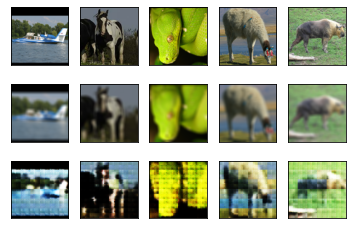

Epoch : [126/300] 

Training Loss: 0.007509	 validation Loss 0.007159
Epoch : [127/300] 

Training Loss: 0.006481	 validation Loss 0.006820
Epoch : [128/300] 

Training Loss: 0.006068	 validation Loss 0.006506
Epoch : [129/300] 

Training Loss: 0.005753	 validation Loss 0.006275
Epoch : [130/300] 

Training Loss: 0.005479	 validation Loss 0.006092
PNSR :20.95 	 SSIM : 0.72
PNSR :17.22 	 SSIM : 0.75
PNSR :20.97 	 SSIM : 0.65
PNSR :22.09 	 SSIM : 0.75
PNSR :18.97 	 SSIM : 0.69


Epoch : [131/300] 

Training Loss: 0.005241	 validation Loss 0.005803
Epoch : [132/300] 

Training Loss: 0.005100	 validation Loss 0.006412
Epoch : [133/300] 

Training Loss: 0.004944	 validation Loss 0.005586
Epoch : [134/300] 

Training Loss: 0.004820	 validation Loss 0.005438
Epoch : [135/300] 

Training Loss: 0.004699	 validation Loss 0.005216
PNSR :21.71 	 SSIM : 0.75
PNSR :18.39 	 SSIM : 0.79
PNSR :21.09 	 SSIM : 0.68
PNSR :21.99 	 SSIM : 0.79
PNSR :19.21 	 SSIM : 0.72


Epoch : [136/300] 

Training Loss: 0.004614	 validation Loss 0.005389
Epoch : [137/300] 

Training Loss: 0.004502	 validation Loss 0.005044
Epoch : [138/300] 

Training Loss: 0.004420	 validation Loss 0.005243
Epoch : [139/300] 

Training Loss: 0.004359	 validation Loss 0.004882
Epoch : [140/300] 

Training Loss: 0.004307	 validation Loss 0.005004
PNSR :20.97 	 SSIM : 0.75
PNSR :18.70 	 SSIM : 0.80
PNSR :21.86 	 SSIM : 0.68
PNSR :21.40 	 SSIM : 0.79
PNSR :18.49 	 SSIM : 0.72


Epoch : [141/300] 

Training Loss: 0.004237	 validation Loss 0.005839
Epoch : [142/300] 

Training Loss: 0.004201	 validation Loss 0.005106
Epoch : [143/300] 

Training Loss: 0.004182	 validation Loss 0.004713
Epoch : [144/300] 

Training Loss: 0.004103	 validation Loss 0.004662
Epoch : [145/300] 

Training Loss: 0.004052	 validation Loss 0.004916
PNSR :21.45 	 SSIM : 0.76
PNSR :19.07 	 SSIM : 0.80
PNSR :21.62 	 SSIM : 0.70
PNSR :21.45 	 SSIM : 0.80
PNSR :18.71 	 SSIM : 0.72


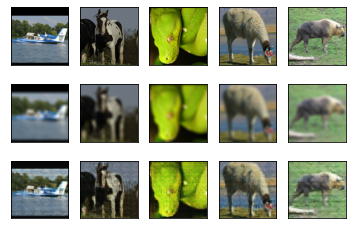

Epoch : [146/300] 

Training Loss: 0.004033	 validation Loss 0.004827
Epoch : [147/300] 

Training Loss: 0.004012	 validation Loss 0.004712
Epoch : [148/300] 

Training Loss: 0.003967	 validation Loss 0.004851
Epoch : [149/300] 

Training Loss: 0.003960	 validation Loss 0.004524
Epoch : [150/300] 

Training Loss: 0.003944	 validation Loss 0.004745
PNSR :21.64 	 SSIM : 0.76
PNSR :18.64 	 SSIM : 0.81
PNSR :22.19 	 SSIM : 0.69
PNSR :20.92 	 SSIM : 0.81
PNSR :18.75 	 SSIM : 0.72


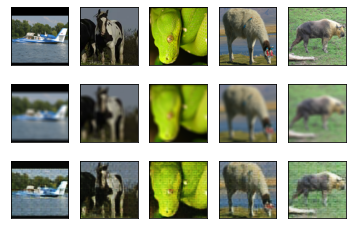

Epoch : [151/300] 

Training Loss: 0.003903	 validation Loss 0.004560
Epoch : [152/300] 

Training Loss: 0.003878	 validation Loss 0.004976
Epoch : [153/300] 

Training Loss: 0.003885	 validation Loss 0.004756
Epoch : [154/300] 

Training Loss: 0.003869	 validation Loss 0.004611
Epoch : [155/300] 

Training Loss: 0.003835	 validation Loss 0.005180
PNSR :20.66 	 SSIM : 0.75
PNSR :18.40 	 SSIM : 0.79
PNSR :21.61 	 SSIM : 0.67
PNSR :20.72 	 SSIM : 0.78
PNSR :18.09 	 SSIM : 0.70


Epoch : [156/300] 

Training Loss: 0.003804	 validation Loss 0.004531
Epoch : [157/300] 

Training Loss: 0.003794	 validation Loss 0.004904
Epoch : [158/300] 

Training Loss: 0.003814	 validation Loss 0.004442
Epoch : [159/300] 

Training Loss: 0.003780	 validation Loss 0.004521
Epoch : [160/300] 

Training Loss: 0.003755	 validation Loss 0.004713
PNSR :21.84 	 SSIM : 0.77
PNSR :19.24 	 SSIM : 0.82
PNSR :23.86 	 SSIM : 0.70
PNSR :22.51 	 SSIM : 0.81
PNSR :19.69 	 SSIM : 0.73


Epoch : [161/300] 

Training Loss: 0.003752	 validation Loss 0.004550
Epoch : [162/300] 

Training Loss: 0.003734	 validation Loss 0.005224
Epoch : [163/300] 

Training Loss: 0.003726	 validation Loss 0.004819
Epoch : [164/300] 

Training Loss: 0.003715	 validation Loss 0.004851
Epoch : [165/300] 

Training Loss: 0.003697	 validation Loss 0.004757
PNSR :21.41 	 SSIM : 0.75
PNSR :19.58 	 SSIM : 0.81
PNSR :22.67 	 SSIM : 0.70
PNSR :21.75 	 SSIM : 0.80
PNSR :18.80 	 SSIM : 0.72


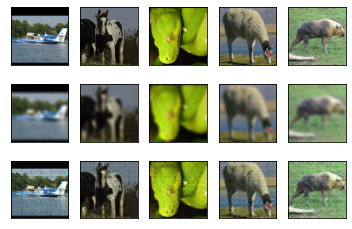

Epoch : [166/300] 

Training Loss: 0.003729	 validation Loss 0.004921
Epoch : [167/300] 

Training Loss: 0.003730	 validation Loss 0.005562
Epoch : [168/300] 

Training Loss: 0.003666	 validation Loss 0.004407
Epoch : [169/300] 

Training Loss: 0.003649	 validation Loss 0.004896
Epoch : [170/300] 

Training Loss: 0.003641	 validation Loss 0.004682
PNSR :21.45 	 SSIM : 0.77
PNSR :19.64 	 SSIM : 0.82
PNSR :23.89 	 SSIM : 0.69
PNSR :22.30 	 SSIM : 0.81
PNSR :19.29 	 SSIM : 0.73


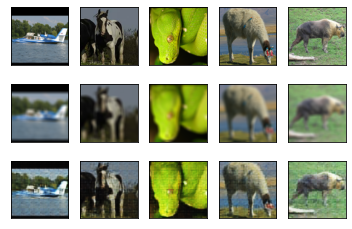

Epoch : [171/300] 

Training Loss: 0.003651	 validation Loss 0.004603
Epoch : [172/300] 

Training Loss: 0.003655	 validation Loss 0.004801
Epoch : [173/300] 

Training Loss: 0.003626	 validation Loss 0.004529
Epoch : [174/300] 

Training Loss: 0.003613	 validation Loss 0.004904
Epoch : [175/300] 

Training Loss: 0.003637	 validation Loss 0.005181
PNSR :21.64 	 SSIM : 0.74
PNSR :19.58 	 SSIM : 0.79
PNSR :22.49 	 SSIM : 0.68
PNSR :22.23 	 SSIM : 0.78
PNSR :19.58 	 SSIM : 0.71


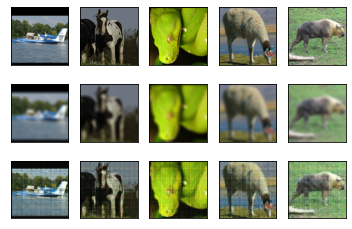

Epoch : [176/300] 

Training Loss: 0.003592	 validation Loss 0.004932
Epoch : [177/300] 

Training Loss: 0.003644	 validation Loss 0.004820
Epoch : [178/300] 

Training Loss: 0.003571	 validation Loss 0.004696
Epoch : [179/300] 

Training Loss: 0.003633	 validation Loss 0.005678
Epoch : [180/300] 

Training Loss: 0.003590	 validation Loss 0.004629
PNSR :21.80 	 SSIM : 0.77
PNSR :19.38 	 SSIM : 0.81
PNSR :23.67 	 SSIM : 0.71
PNSR :21.84 	 SSIM : 0.80
PNSR :19.25 	 SSIM : 0.73


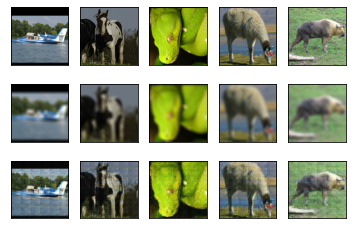

Epoch : [181/300] 

Training Loss: 0.003567	 validation Loss 0.004347
Epoch : [182/300] 

Training Loss: 0.003569	 validation Loss 0.004741
Epoch : [183/300] 

Training Loss: 0.003573	 validation Loss 0.004629
Epoch : [184/300] 

Training Loss: 0.003540	 validation Loss 0.004527
Epoch : [185/300] 

Training Loss: 0.003596	 validation Loss 0.004570
PNSR :22.36 	 SSIM : 0.78
PNSR :19.91 	 SSIM : 0.83
PNSR :23.51 	 SSIM : 0.72
PNSR :22.04 	 SSIM : 0.81
PNSR :19.41 	 SSIM : 0.74


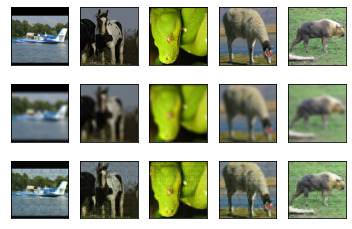

Epoch : [186/300] 

Training Loss: 0.003545	 validation Loss 0.004654
Epoch : [187/300] 

Training Loss: 0.003545	 validation Loss 0.004800
Epoch : [188/300] 

Training Loss: 0.003558	 validation Loss 0.004798
Epoch : [189/300] 

Training Loss: 0.003532	 validation Loss 0.004518
Epoch : [190/300] 

Training Loss: 0.003549	 validation Loss 0.005030
PNSR :22.11 	 SSIM : 0.75
PNSR :19.28 	 SSIM : 0.80
PNSR :23.63 	 SSIM : 0.69
PNSR :21.31 	 SSIM : 0.78
PNSR :19.33 	 SSIM : 0.71


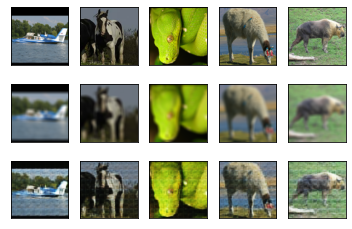

Epoch : [191/300] 

Training Loss: 0.003536	 validation Loss 0.004841
Epoch : [192/300] 

Training Loss: 0.003513	 validation Loss 0.004708
Epoch : [193/300] 

Training Loss: 0.003536	 validation Loss 0.005091
Epoch : [194/300] 

Training Loss: 0.003517	 validation Loss 0.004584
Epoch : [195/300] 

Training Loss: 0.003564	 validation Loss 0.004737
PNSR :22.06 	 SSIM : 0.76
PNSR :18.78 	 SSIM : 0.81
PNSR :21.43 	 SSIM : 0.68
PNSR :20.35 	 SSIM : 0.78
PNSR :19.16 	 SSIM : 0.71


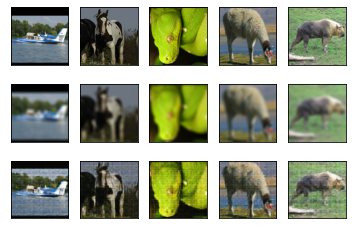

Epoch : [196/300] 

Training Loss: 0.003507	 validation Loss 0.004529
Epoch : [197/300] 

Training Loss: 0.003512	 validation Loss 0.004690
Epoch : [198/300] 

Training Loss: 0.003498	 validation Loss 0.004712
Epoch : [199/300] 

Training Loss: 0.003517	 validation Loss 0.004952
Epoch : [200/300] 

Training Loss: 0.003506	 validation Loss 0.004512
PNSR :21.64 	 SSIM : 0.77
PNSR :20.08 	 SSIM : 0.82
PNSR :23.77 	 SSIM : 0.70
PNSR :21.61 	 SSIM : 0.80
PNSR :19.12 	 SSIM : 0.73


Epoch : [201/300] 

Training Loss: 0.003500	 validation Loss 0.005235
Epoch : [202/300] 

Training Loss: 0.003500	 validation Loss 0.005253
Epoch : [203/300] 

Training Loss: 0.003488	 validation Loss 0.004810
Epoch : [204/300] 

Training Loss: 0.003495	 validation Loss 0.004705
Epoch : [205/300] 

Training Loss: 0.003476	 validation Loss 0.004687
PNSR :21.46 	 SSIM : 0.76
PNSR :19.02 	 SSIM : 0.80
PNSR :22.42 	 SSIM : 0.70
PNSR :20.89 	 SSIM : 0.79
PNSR :19.21 	 SSIM : 0.73


Epoch : [206/300] 

Training Loss: 0.003530	 validation Loss 0.005306
Epoch : [207/300] 



KeyboardInterrupt: ignored

In [14]:

n_epochs = 300

device = get_device()
print(device)

model_strong = DenosingAutoencoder()
optimizer_strong = torch.optim.Adam(model_strong.parameters(), lr=0.001, weight_decay  = 1e-04)
model_strong=model_strong.to(device)

strong_train_loss_graph = np.array([])
strong_val_loss_graph = np.array([])




start = time.time()

for epoch in range(1, n_epochs+1):
    print(f"Epoch : [{epoch}/{n_epochs}]","\n")
    model_strong.train()
    time.sleep(1.0)
    # monitor training loss
    train_loss = 0.0
    total_train_loss = 0.0
    val_loss = 0.0
    total_val_loss = 0.0

    '''
    Total되는 새로운 변수를 하나 만들어줘야지 val_loss가 제대로 더해진다. 안 하면 이상하게 안 더해진다.
    '''
    #Training
    for i,(tr_img, hat_img) in enumerate(zip(tr_dataloader,strong_hat_tr_dataloader)):
        tr_images,_ = tr_img
#        print(tr_images_arr.shape)
        hat_tr_images,_ = hat_img
#check   print(type(hat_tr_images))
        hat_tr_images = hat_tr_images.to(device) #데이터 형식이 Byte이기 때문에 신경망 성분인 float으로 변환해야 한다.
#check   print(tr_images.shape)
        tr_outputs =model_strong(hat_tr_images)
        optimizer_strong.zero_grad()
#check0. print(hat_tr_images.shape)  
#check   print(tr_outputs.shape)
        tr_images = tr_images.to(device)
        loss = mse_loss(tr_outputs, tr_images).to(device) #여기에 쿠다를 부착하니 성능 급 상승함.
        loss.backward()#.to(device)
        optimizer_strong.step()
        train_loss = loss.clone().detach().item()
        total_train_loss += train_loss

#check1.        print(f"minibatch : {i}, train_loss_added : {total_train_loss/1250}")
    total_train_loss = total_train_loss/len(tr_dataloader)
    strong_train_loss_graph = np.append(strong_train_loss_graph, total_train_loss)

    
    #evaluation
    model_strong.eval()
    time.sleep(1.0)
    with torch.no_grad():   
        optimizer_strong.zero_grad()
        
        for i, (img, hat_img) in enumerate(zip(val_dataloader, strong_hat_val_dataloader)):
                val_img, _ = img
                hat_val_img,_ = hat_img
                 
                hat_val_img = hat_val_img.to(device)
                val_outputs =model_strong(hat_val_img)
#                print('val_outputs shape:',val_outputs.shape )
                val_img = val_img.to(device)
                val_loss = mse_loss(val_outputs, val_img)#.to(device)
                val_loss = val_loss.item()
                total_val_loss += val_loss
#check2.     print(f"val_mini_batch : {i }, val_loss_added : {total_val_loss/313}")                
        total_val_loss = total_val_loss/len(val_dataloader)
        strong_val_loss_graph = np.append(strong_val_loss_graph, total_val_loss)
        print('Training Loss: {:.6f}\t validation Loss {:.6f}'.format(total_train_loss, total_val_loss))
          
#check3.     
        if (epoch)%5 == 0:

          for j in range(5):
            val_ssim = ssim(val_img[j].cpu().numpy().transpose(1, 2, 0), val_outputs[j].cpu().numpy().transpose(1, 2, 0), multichannel=True, gaussian_weights=True, use_sample_covariance=False)
            val_psnr = Get_psnr(val_img[j], val_outputs[j])
            print('PNSR :{:.2f} \t SSIM : {:.2f}'.format(val_psnr,val_ssim))
            
            ax = plt.subplot(3,5,j+1)
            plt.imshow(val_img[j].cpu().numpy().transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)


            ax = plt.subplot(3,5,j+5+1)
            plt.imshow(hat_val_img[j].cpu().numpy().transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)


            ax = plt.subplot(3, 5, j+5+5+1)
            plt.imshow(val_outputs[j].cpu().numpy().transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

          plt.show()   

end = time.time()

total_time = (end-start)/60
print("execution time : {:.1f}min".format(total_time))

In [24]:
summary(model_strong,(3,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             416
       BatchNorm2d-2           [-1, 32, 48, 48]              64
              ReLU-3           [-1, 32, 48, 48]               0
            Conv2d-4           [-1, 64, 24, 24]           8,256
       BatchNorm2d-5           [-1, 64, 24, 24]             128
              ReLU-6           [-1, 64, 24, 24]               0
            Conv2d-7          [-1, 128, 12, 12]          32,896
       BatchNorm2d-8          [-1, 128, 12, 12]             256
              ReLU-9          [-1, 128, 12, 12]               0
           Conv2d-10            [-1, 256, 6, 6]         131,328
      BatchNorm2d-11            [-1, 256, 6, 6]             512
             ReLU-12            [-1, 256, 6, 6]               0
          Flatten-13                 [-1, 9216]               0
        Unflatten-14            [-1, 25

In [25]:
# 모델의 state_dict 출력
print("Model's state_dict:")
for param_tensor in model_strong.state_dict():
    print(param_tensor, "\t", model_strong.state_dict()[param_tensor].size())

# 옵티마이저의 state_dict 출력
print("Optimizer's state_dict:")
for var_name in optimizer_strong.state_dict():
    print(var_name, "\t", optimizer_strong.state_dict()[var_name])

Model's state_dict:
encoder.0.weight 	 torch.Size([32, 3, 2, 2])
encoder.0.bias 	 torch.Size([32])
encoder.1.weight 	 torch.Size([32])
encoder.1.bias 	 torch.Size([32])
encoder.1.running_mean 	 torch.Size([32])
encoder.1.running_var 	 torch.Size([32])
encoder.1.num_batches_tracked 	 torch.Size([])
encoder.3.weight 	 torch.Size([64, 32, 2, 2])
encoder.3.bias 	 torch.Size([64])
encoder.4.weight 	 torch.Size([64])
encoder.4.bias 	 torch.Size([64])
encoder.4.running_mean 	 torch.Size([64])
encoder.4.running_var 	 torch.Size([64])
encoder.4.num_batches_tracked 	 torch.Size([])
encoder.6.weight 	 torch.Size([128, 64, 2, 2])
encoder.6.bias 	 torch.Size([128])
encoder.7.weight 	 torch.Size([128])
encoder.7.bias 	 torch.Size([128])
encoder.7.running_mean 	 torch.Size([128])
encoder.7.running_var 	 torch.Size([128])
encoder.7.num_batches_tracked 	 torch.Size([])
encoder.9.weight 	 torch.Size([256, 128, 2, 2])
encoder.9.bias 	 torch.Size([256])
encoder.10.weight 	 torch.Size([256])
encoder.10.bia

In [29]:
#checkpoint
torch.save({
            'epoch' : e,
            'model_state_dict' : model_strong.state_dict(),
            'optimizer_state_dict' : optimizer_strong.state_dict(),
            'loss' : total_train_loss,
},

f'/content/drive/Mydrive/Colab Notebooks/saved_model/checkpoint_model_{e}_{total_train_loss}.pt'

SyntaxError: ignored

In [30]:
best_model_state =  deepcopy(model_strong.state_dict()) 

NameError: ignored

NameError: ignored

In [31]:
model_name = 'Gaussian_strong_debluring_model'

path = f'/content/drive/MyDrive/Colab Notebooks/saved_model/{model_name}'

torch.save(model_strong.state_dict(), path)

In [106]:
device = torch.device("cuda")
strong_load = DenosingAutoencoder()
strong_load.load_state_dict(torch.load(path, map_location="cuda:0"))  # 사용할 GPU 장치 번호를 선택합니다.
strong_load = strong_load.to(device)

In [107]:
strong_load.eval()

load_img,_ = next(iter(strong_hat_test_dataloader))
plt.imshow(load_img[0].numpy().transpose(1,2,0))

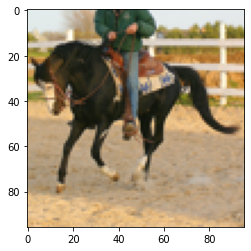

In [109]:
load_origin_img,_ = next(iter(test_dataloader))
plt.imshow(load_origin_img[0].numpy().transpose(1,2,0))

In [119]:
load_origin_img = load_origin_img.to(device)
load_origin_ouput_img = strong_load(load_origin_img)
plt.imshow(load_origin_output_img[0].detach().cpu().numpy().transpose(1,2,0))

RuntimeError: ignored

In [88]:
load_img[0].shape

torch.Size([3, 96, 96])

In [89]:
load_img.shape

torch.Size([2048, 3, 96, 96])

In [103]:
load_img = load_img.to(device)
load_output_img = strong_load(load_img)
load_output_img.shape


torch.Size([2048, 3, 96, 96])

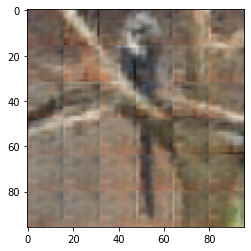

In [104]:
plt.imshow(load_output_img[1].detach().cpu().numpy().transpose(1,2,0))


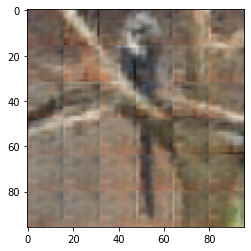

In [105]:
plt.imshow(load_output_img[1].detach().cpu().numpy().transpose(1,2,0))


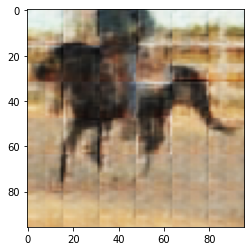

In [91]:
plt.imshow(load_output_img[0].detach().cpu().numpy().transpose(1,2,0))


# strong test

# strong graph

# test graph for (average psnr, ssim)

In [ ]:
from skimage.metrics import structural_similarity as ssim

sum_ssim = 0.0
sum_psnr = 0.0
avg_ssim = 0.0
avg_psnr = 0.0

model_strong.eval()
with torch.no_grad():
    optimizer_strong.zero_grad()
    for i, (test_img, hat_test_img) in enumerate(zip(test_dataloader, Gs_blur_strong_test_dataloader)):
        
        strong_test_img, _ = test_img
        strong_test_img = strong_test_img.to(device)
        strong_test_hat_img, _ = hat_test_img
        strong_test_hat_img = strong_test_hat_img.to(device)

        test_outputs = model_strong(strong_test_hat_img)
        
    for j in range(10):
        img1_cpu = strong_test_img[j].cpu().numpy().transpose(1, 2, 0)
        img1_float64 = img1_cpu.astype(np.float64)
        img2_cpu = test_outputs[j].cpu().numpy()
        img2_float64 = img2_cpu.astype(np.float64).transpose(1, 2, 0)
        
        strong_ssim = ssim(img1_float64, img2_float64, multichannel=True, gaussian_weights=True)
        strong_psnr = Get_psnr(strong_test_img[j], test_outputs[j], max_val = 1.0)
        sum_psnr+=strong_psnr
        sum_ssim+=strong_ssim
        print('PNSR :{:.2f} \t SSIM : {:.2f}'.format(strong_psnr,strong_ssim))
        
        ax = plt.subplot(3,10,j+1)
        plt.imshow(strong_test_img[j].cpu().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


        ax = plt.subplot(3,10,j+10+1)
        plt.imshow(strong_test_hat_img[j].cpu().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


        ax = plt.subplot(3,10, j+20+1)
        plt.imshow(test_outputs[j].cpu().detach().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()   
avg_psnr=sum_psnr/10
avg_ssim=sum_ssim/10

print("avg_psnr : {:.2f}".format(avg_psnr))
print("avg_ssim : {:.2f}".format(avg_ssim))


In [62]:
data = iter(Gs_blur_strong_val_dataloader)
img,_ = next(data)
img_uint8 = img[0].numpy().astype('uint8')

plt.imshow(img_uint8.transpose(1,2,0))
img[0]

NameError: ignored

In [ ]:
print(img[0].shape)